In [1]:
# Lesson 03

In [2]:
import random
from collections import defaultdict
import numpy as np

In [3]:
class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):

        raise NotImplemented

In [4]:
class Node:
    def __init__(self, inputs=[], name=None, is_trainable=True):
        self.inputs = inputs
        self.outputs = []
        self.name = name
        self.is_trainable = is_trainable
        
        for n in self.inputs:
            n.outputs.append(self)
        
        self.value = None
        
        self.gradients = {}
        
    def forward(self):
        raise NotImplementedError
    
    def backward(self):
        raise NotImplementedError
    
    def __repr__(self):
        return self.name

In [5]:
class Placeholder(Node):
    def __init__(self, name, is_trainable=True):
        Node.__init__(self, name=name, is_trainable=is_trainable)
        
    def forward(self, value=None):
        if value is not None: self.value = value
    
    def backward(self):
        self.gradients = {}
        for n in self.outputs:
            self.gradients[self] = n.gradients[self] * 1

In [6]:

class Linear(Node):
    def __init__(self, x=None, weigth=None, bias=None, name=None, is_trainable=False):
        Node.__init__(self, [x, weigth, bias], name=name, is_trainable=is_trainable)
        
    def forward(self):
        k, x, b = self.inputs[1], self.inputs[0], self.inputs[2]
        self.value = k.value * x.value + b.value
        
    def backward(self):
        k, x, b = self.inputs[1], self.inputs[0], self.inputs[2]
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            
            self.gradients[k] = grad_cost * x.value
            
            self.gradients[x] = grad_cost * k.value
            
            self.gradients[b] = grad_cost * 1

In [7]:
       
class Sigmoid(Node):
    def __init__(self, x, name=None, is_trainable=False):
        Node.__init__(self, [x], name=name, is_trainable=is_trainable)
        self.x = self.inputs[0]
        
    def _sigmoid(self, x):
        return 1. / (1 + np.exp(-1 * x))
    
    def forward(self):
        self.value = self._sigmoid(self.x.value)
        
    def partial(self):
        return self._sigmoid(self.x.value) * (1 - self._sigmoid(self.x.value))
    
    def backward(self):
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.x] = grad_cost * self.partial() 
    #    print(self.gradients)

In [8]:
   
class Relu(Node):
    def __init__(self, x, name=None, is_trainable=False):
        Node.__init__(self, [x], name=name, is_trainable=is_trainable)
        self.x = x
        
    def forward(self):
        self.value = self.x.value * (self.x.value > 0)
        
    def backward(self):
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.x] = grad_cost * (self.x.value > 0) 
        

In [9]:

class L2_LOSS(Node):
    def __init__(self, y, y_hat, name=None, is_trainable=False):
        Node.__init__(self, [y, y_hat], name=name, is_trainable=is_trainable)
        self.y = y
        self.y_hat = y_hat
        
    def forward(self):        
        y_v = np.array(self.y.value)
        yhat_v = np.array(self.y_hat.value)
        self.value = np.mean((y_v - yhat_v) ** 2)
        
    def backward(self):
        # 1/n sum (y- yhat)**2
        y_v = np.array(self.y.value)
        yhat_v = np.array(self.y_hat.value)
        self.gradients[self.y] = 2 * np.mean((y_v - yhat_v))
        self.gradients[self.y_hat] = -2 * np.mean((y_v - yhat_v))
     #   print(self.gradients)

In [10]:
def toplogic(graph):
    sorted_node = []
    
    while len(graph) > 0: 

        all_inputs = []
        all_outputs = []
        
        for n in graph:
            all_inputs += graph[n]
            all_outputs.append(n)
        
        all_inputs = set(all_inputs)
        all_outputs = set(all_outputs)
    
        need_remove = all_outputs - all_inputs  # which in all_inputs but not in all_outputs
    
        if len(need_remove) > 0: 
            node = random.choice(list(need_remove))
            
            visited_next = [node]
            if len(graph) == 1:  visited_next += graph[node]
                
            graph.pop(node)
            sorted_node += visited_next

            for _, links in graph.items():
                if node in links: links.remove(node)
        else:
            break
        
    return sorted_node

In [11]:
def topological_sort_feed_dict(feed_dict):
    graph = convert_feed_dict_to_graph(feed_dict)
    
    return toplogic(graph)

In [12]:
def convert_feed_dict_to_graph(feed_dict):
    computing_graph = defaultdict(list)
    
    nodes = [n for n in feed_dict]
    
    while nodes:
        n = nodes.pop(0) 
        
        if isinstance(n, Placeholder):
            n.value = feed_dict[n]
        
        if n in computing_graph: continue

        for m in n.outputs:
            computing_graph[n].append(m)
            nodes.append(m)
    
    return computing_graph

In [13]:
def forward(graph_order, monitor=False):
    for node in graph_order:
        if monitor: print('forward compuiting -- {}'.format(node))
        node.forward()

In [14]:
def backward(graph_order, monitor=False):
    for node in graph_order[::-1]:
        if monitor: print('backward computing -- {}'.format(node))
        node.backward()

In [15]:
def run_one_epoch(graph_order, monitor=False):
    forward(graph_order, monitor)
    backward(graph_order, monitor)

In [16]:
def optimize(graph, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in graph:
        if t.is_trainable:
            t.value += -1 * learning_rate * t.gradients[t]

In [19]:
from sklearn.datasets import load_boston
from tqdm import tqdm

In [20]:
data = load_boston()
X_, y_ = data['data'], data['target']
X_rm = X_[:, 5]

w1_, b1_ = np.random.normal(), np.random.normal()
w2_, b2_ = np.random.normal(), np.random.normal()
w3_, b3_ = np.random.normal(), np.random.normal()


X, y = Placeholder(name='X', is_trainable=False), Placeholder(name='y', is_trainable=False)
w1, b1 = Placeholder(name='w1'), Placeholder(name='b1')
w2, b2 = Placeholder(name='w2'), Placeholder(name='b2')

In [21]:
# build model
output1 = Linear(X, w1, b1, name='linear-01')
output2 = Sigmoid(output1, name='activation')
#output2 = Relu(output1, name='activation')
y_hat = Linear(output2, w2, b2, name='y_hat')
cost = L2_LOSS(y, y_hat, name='cost')
feed_dict = {
    X: X_rm,
    y: y_,
    w1: w1_,
    w2: w2_,
    b1: b1_,
    b2: b2_,
}

In [22]:
graph_sort = topological_sort_feed_dict(feed_dict)

epoch = 1000

batch_num = len(X_rm)

learning_rate = 1e-3
losses = []

In [23]:
from tqdm import tqdm

for e in tqdm(range(epoch)):
    loss = 0
    
    for b in range(batch_num):
        index = np.random.choice(range(len(X_rm)))
        X.value = X_rm[index]
        y.value = y_[index]
    
        run_one_epoch(graph_sort, monitor=False)
    
        optimize(graph_sort, learning_rate)
        
        loss += cost.value

    losses.append(loss / batch_num)

100%|██████████| 1000/1000 [00:25<00:00, 39.45it/s]


In [24]:
import matplotlib.pyplot as plt

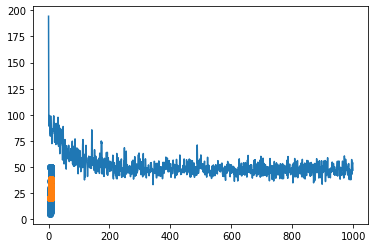

In [25]:
plt.plot(losses)
def predicate(x, graph):
    X.value = x
    forward(graph)
    return y_hat.value
predicate(7, graph_sort)
plt.scatter(X_rm, y_)
plt.scatter(X_rm, [predicate(x, graph_sort) for x in X_rm])

## 多维向量版

In [33]:
import numpy as np
import random

In [34]:
class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):

        raise NotImplemented

In [35]:
       
class Placeholder(Node):
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N


In [36]:

class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

In [37]:

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):

        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

In [38]:

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.

In [39]:


class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff

In [40]:

def forward_and_backward(graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

In [41]:

def toplogic(graph):
    sorted_node = []
    
    while len(graph) > 0: 

        all_inputs = []
        all_outputs = []
        
        for n in graph:
            all_inputs += graph[n]
            all_outputs.append(n)
        
        all_inputs = set(all_inputs)
        all_outputs = set(all_outputs)
    
        need_remove = all_outputs - all_inputs  # which in all_inputs but not in all_outputs
    
        if len(need_remove) > 0: 
            node = random.choice(list(need_remove))

            need_to_visited = [node]

            if len(graph) == 1: need_to_visited += graph[node]
                
            graph.pop(node)
            sorted_node += need_to_visited
        
            for _, links in graph.items():
                if node in links: links.remove(node)
        else: # have cycle
            break
        
    return sorted_node

In [42]:

from collections import defaultdict

In [43]:
def convert_feed_dict_to_graph(feed_dict):
    computing_graph = defaultdict(list)
    
    nodes = [n for n in feed_dict]
    
    while nodes:
        n = nodes.pop(0) 
        
        if isinstance(n, Placeholder):
            n.value = feed_dict[n]
        
        if n in computing_graph: continue

        for m in n.outputs:
            computing_graph[n].append(m)
            nodes.append(m)
    
    return computing_graph

In [44]:

def topological_sort_feed_dict(feed_dict):
    graph = convert_feed_dict_to_graph(feed_dict)
    
    return toplogic(graph)

In [45]:

def optimize(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [46]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

In [47]:
# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

In [48]:
# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

In [49]:
# Neural network
X, y = Placeholder(), Placeholder()
W1, b1 = Placeholder(), Placeholder()
W2, b2 = Placeholder(), Placeholder()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}


In [50]:

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort_feed_dict(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

Total number of examples = 506


In [51]:
losses = []

In [53]:
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        optimize(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss/steps_per_epoch)

Epoch: 1, Loss: 159.569
Epoch: 101, Loss: 6.494
Epoch: 201, Loss: 5.219
Epoch: 301, Loss: 4.441
Epoch: 401, Loss: 4.168
Epoch: 501, Loss: 4.025
Epoch: 601, Loss: 3.703
Epoch: 701, Loss: 3.965
Epoch: 801, Loss: 3.937
Epoch: 901, Loss: 3.706
Epoch: 1001, Loss: 3.527
Epoch: 1101, Loss: 3.694
Epoch: 1201, Loss: 3.186
Epoch: 1301, Loss: 3.717
Epoch: 1401, Loss: 3.479
Epoch: 1501, Loss: 3.684
Epoch: 1601, Loss: 3.606
Epoch: 1701, Loss: 2.941
Epoch: 1801, Loss: 3.149
Epoch: 1901, Loss: 3.783
Epoch: 2001, Loss: 3.282
Epoch: 2101, Loss: 4.192
Epoch: 2201, Loss: 3.231
Epoch: 2301, Loss: 3.787
Epoch: 2401, Loss: 3.715
Epoch: 2501, Loss: 3.550
Epoch: 2601, Loss: 2.991
Epoch: 2701, Loss: 3.493
Epoch: 2801, Loss: 3.230
Epoch: 2901, Loss: 3.111
Epoch: 3001, Loss: 3.549
Epoch: 3101, Loss: 3.770
Epoch: 3201, Loss: 3.012
Epoch: 3301, Loss: 3.172
Epoch: 3401, Loss: 3.989
Epoch: 3501, Loss: 3.332
Epoch: 3601, Loss: 3.416
Epoch: 3701, Loss: 3.209
Epoch: 3801, Loss: 3.358
Epoch: 3901, Loss: 3.308
Epoch: 400

## 2-Dimensions Version

In [54]:
import pandas as pd

In [55]:
dataframe = pd.DataFrame(data['data'])
dataframe.columns = data['feature_names']

In [56]:
dataframe

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [57]:
training_data = dataframe[['RM', 'LSTAT']]

In [58]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

In [59]:
# Load data
data = load_boston()
X_ = training_data
y_ = data['target']

In [60]:
# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

In [61]:
# Neural network
X, y = Placeholder(), Placeholder()
W1, b1 = Placeholder(), Placeholder()
W2, b2 = Placeholder(), Placeholder()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}


In [62]:

epochs = 200
# Total number of examples
m = X_.shape[0]
batch_size = 1
steps_per_epoch = m // batch_size

graph = topological_sort_feed_dict(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

Total number of examples = 506


In [63]:
losses = []

for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
    
        forward_and_backward(graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        optimize(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss/steps_per_epoch)

Epoch: 1, Loss: 40.059
Epoch: 101, Loss: 14.555


In [64]:
X.value = np.array([[6, 8]])
forward_and_backward(graph)
graph[-2].value[0][0]

16.47659334705788

In [65]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [66]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [67]:
ax = fig.gca(projection='3d')

/var/folders/jd/jhbp58m554l8fyt81nfks5jm0000gn/T/ipykernel_79489/4066479012.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [68]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

Text(0.5, 0, 'Price')

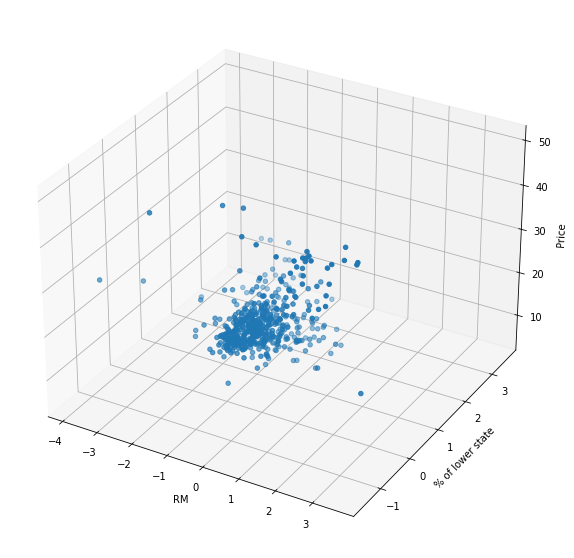

In [71]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Make data.
X = X_.values[:, 0]
Y = X_.values[:, 1]
Z = y_

# Plot the surface.
rm_and_lstp_price = ax.scatter(X, Y, Z)
ax.set_xlabel('RM')
ax.set_ylabel('% of lower state')
ax.set_zlabel('Price')

In [83]:
values = training_data.values
values
# print(values)
predicate_result = []
for rm, ls in values:
    a = np.array(rm, ls)
    print(a)

X

6.575
6.421
7.185
6.998
7.147
6.43
6.012
6.172
5.631
6.004
6.377
6.009
5.889
5.949
6.096
5.834
5.935
5.99
5.456
5.727
5.57
5.965
6.142
5.813
5.924
5.599
5.813
6.047
6.495
6.674
5.713
6.072
5.95
5.701
6.096
5.933
5.841
5.85
5.966
6.595
7.024
6.77
6.169
6.211
6.069
5.682
5.786
6.03
5.399
5.602
5.963
6.115
6.511
5.998
5.888
7.249
6.383
6.816
6.145
5.927
5.741
5.966
6.456
6.762
7.104
6.29
5.787
5.878
5.594
5.885
6.417
5.961
6.065
6.245
6.273
6.286
6.279
6.14
6.232
5.874
6.727
6.619
6.302
6.167
6.389
6.63
6.015
6.121
7.007
7.079
6.417
6.405
6.442
6.211
6.249
6.625
6.163
8.069
7.82
7.416
6.727
6.781
6.405
6.137
6.167
5.851
5.836
6.127
6.474
6.229
6.195
6.715
5.913
6.092
6.254
5.928
6.176
6.021
5.872
5.731
5.87
6.004
5.961
5.856
5.879
5.986
5.613
5.693
6.431
5.637
6.458
6.326
6.372
5.822
5.757
6.335
5.942
6.454
5.857
6.151
6.174
5.019
5.403
5.468
4.903
6.13
5.628
4.926
5.186
5.597
6.122
5.404
5.012
5.709
6.129
6.152
5.272
6.943
6.066
6.51
6.25
7.489
7.802
8.375
5.854
6.101
7.929
5.877
6.319
6

array([ 4.13671889e-01,  1.94274453e-01,  1.28271368e+00,  1.01630251e+00,
        1.22857665e+00,  2.07096381e-01, -3.88410945e-01, -1.60465557e-01,
       -9.31205901e-01, -3.99808215e-01,  1.31589471e-01, -3.92684921e-01,
       -5.63643963e-01, -4.78164442e-01, -2.68739617e-01, -6.42000190e-01,
       -4.98109663e-01, -4.19753436e-01, -1.18052117e+00, -7.94438668e-01,
       -1.01811008e+00, -4.55369903e-01, -2.03205317e-01, -6.71918022e-01,
       -5.13780909e-01, -9.76794979e-01, -6.71918022e-01, -3.38547892e-01,
        2.99699195e-01,  5.54713098e-01, -8.14383890e-01, -3.02931425e-01,
       -4.76739783e-01, -8.31479794e-01, -2.68739617e-01, -5.00958981e-01,
       -6.32027579e-01, -6.19205651e-01, -4.53945244e-01,  4.42165063e-01,
        1.05334363e+00,  6.91480331e-01, -1.64739533e-01, -1.04903869e-01,
       -3.07205401e-01, -8.58548308e-01, -7.10383806e-01, -3.62767089e-01,
       -1.26172671e+00, -9.72521003e-01, -4.58219220e-01, -2.41671102e-01,
        3.22493734e-01, -

In [85]:
predicate_result = []
for rm, ls in values:
    X.value = np.array([[rm, ls]])
    forward_and_backward(graph)
    predicate_result.append(graph[-2].value[0][0])

AttributeError: 'numpy.ndarray' object has no attribute 'value'

In [ ]:
predicate_result = np.array(predicate_result)

In [86]:
%matplotlib notebook

In [87]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Make data.
X = X_.values[:, 0]
Y = X_.values[:, 1]
Z = predicate_result

# Plot the surface.
rm_and_lstp_price = ax.plot_trisurf(X, Y, Z, color='yellow')

ax.set_xlabel('RM')
ax.set_ylabel('% of lower state')
ax.set_zlabel('Predicated-Price')

<IPython.core.display.Javascript object>

IndexError: index 365 is out of bounds for axis 0 with size 0